# Project - Plant Seedlings Image Classification

Can you differentiate a weed from a crop seedling?
The ability to do so effectively, can mean better crop yields and better stewardship of the environment.
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages. 

#### Domain 
Agriculture

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#0e92ea"> Submitted by: Deep Singh Chauhan


Imported basic libraries


In [1]:
#Load Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Importing Google Drive for data loading and mounting 

In [2]:
from google.colab import drive

In [3]:
# Mounting Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Loading dataset into dataframe
df = np.load('/content/drive/My Drive/Colab Notebooks/Computer Vision/images.npy')

In [5]:
# checking shape
df.shape

(4750, 128, 128, 3)

In [6]:
# data has 4750 images 
# The size of each image is 128x128 pixels.
# Each image has 3 color channels.

In [7]:
# Sequential model in tensorflow.keras expects data to be in the format (n_e, n_h, n_w, n_c)
# n_e= number of examples, n_h = height, n_w = width, n_c = number of channels
# and our dataset is already in that shape so we can continue with same shape

In [8]:
# loading target labels
target = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Computer Vision/Labels.csv')

In [9]:
# checking label head
target.head(2)

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill


In [10]:
# size of the labels dataframe
target.shape

(4750, 1)

In [11]:
# 4750 labels are present in target

In [12]:
# count of each plant in labels
target['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

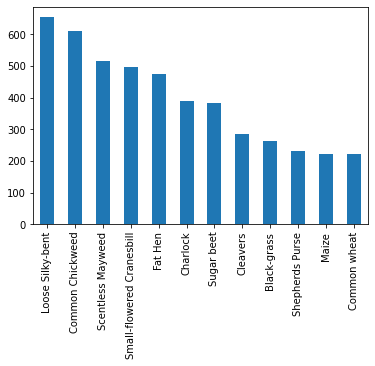

In [13]:
# Plot of label types count
target['Label'].value_counts().plot(kind='bar')

In [14]:
# from above grapf we can see, data have different counts of images for different species. So, data is unbalanced
# I will continue using same set.

Displaying Images

In [15]:
# Import necessary libraries.
import cv2
from google.colab.patches import cv2_imshow

Text(0.5, 1.0, 'Common Chickweed')

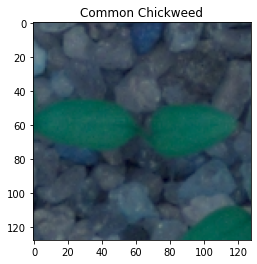

In [16]:
# visualizing one image on index 1981, along with its label as Title
i=1981
img = df[i]
plt.imshow(img)
plt.title(target['Label'][i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


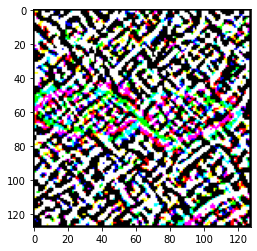

In [17]:
#sobel display
sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

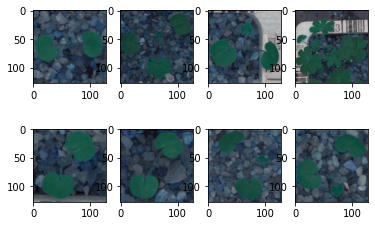

In [18]:
# visualizing few images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(df[i])

**Data Pre-processing**

In [19]:
# using variable name X for attributes
X = df

In [20]:
print(len(X))

4750


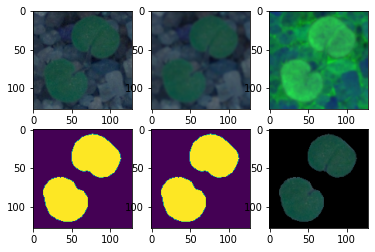

In [21]:
# pre prosessing images with blurring, hsv, masking and highlighting green 
greenBlurredImages = []

for ind, img in enumerate(X):
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    greenBlurredImages.append(clear)  # Append image without backgroung
    
    # Show 200th image as exmaple
    if ind == 200:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False


Original


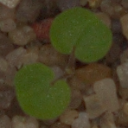

Blurred and Green


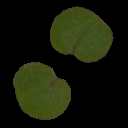

In [22]:
# Visualize data after pre-processing
i = 200
print('Original')
cv2_imshow(df[i])
print('Blurred and Green')
cv2_imshow(greenBlurredImages[i])

In [23]:
# assinging back to X variable
X = np.asarray(greenBlurredImages)

Normalizing Input

In [24]:
X.max()

255

In [25]:
# we must normalize our data as it is always required in neural network models
# we can achieve this by dividing the RGB codes with 255 (which is the maximum RGB code minus the minimum RGB code)
# make sure that the values are float so that we can get decimal points after division

In [26]:
# changing data type
X = X.astype('float32')

In [27]:
# Dividing by 255 for normalizing
X /= 255.0 

In [28]:
X.max()

1.0

from normalize data


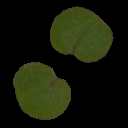

In [29]:
print('from normalize data')
cv2_imshow(X[i]*255)

**Making data compatible**

Convert labels to one-hot-vectors

In [30]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [31]:
# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(target['Label'])
print("Classes: " + str(le.classes_))
encodedLabels = le.transform(target['Label'])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [32]:
encodedLabels

array([10, 10, 10, ...,  6,  6,  6])

In [33]:
# display label name from number
print(le.classes_[0])

Black-grass


In [34]:
# Make labels categorical
y = np_utils.to_categorical(encodedLabels)
num_classes = y.shape[1]
print("Number of classes: " + str(num_classes))

Number of classes: 12


In [35]:
num_classes

12

In [36]:
print(type(y))
print(type(target['Label']))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [37]:
y.shape

(4750, 12)

In [38]:
# Print the label for y_train[0]
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [39]:
X.shape

(4750, 128, 128, 3)

Split the dataset into training, testing, and validation set

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# Train test split using features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [42]:
# spitting test again into validation and test set
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=1)

In [43]:
# copied from problem statement
# Hint: First split images and labels into training and testing set with test_size = 0.3. 
# Then further split test data into test and validation set with test_size = 0.5

In [44]:
# shape of all sets
print(f'training shapes: {X_train.shape}, {y_train.shape}')
print(f'validation shapes: {X_validation.shape}, {y_validation.shape}')
print(f'testing shapes: {X_test.shape}, {y_test.shape}')

training shapes: (3325, 128, 128, 3), (3325, 12)
validation shapes: (712, 128, 128, 3), (712, 12)
testing shapes: (713, 128, 128, 3), (713, 12)


In [45]:
print("Max value in X_train:", X_train.max())
print("Min value in X_train:", X_train.min())

Max value in X_train: 1.0
Min value in X_train: 0.0


**Building CNN**

In [46]:
from tensorflow.keras import datasets, models, layers, optimizers

In [47]:
epochs = 38
batch_size = 32
# num_classes from target variable above

In [48]:
# Define CNN model

model = models.Sequential()

model.add(layers.Conv2D(128, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [49]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [50]:
# Training the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [51]:
# Adding Early stopping callback to the fit function is going to stop the training,
# if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

# Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
# Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

Fit model

In [52]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_validation, y_validation),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/38
104/104 [==============================] - ETA: 0s - loss: 3.3829 - accuracy: 0.2135
Epoch 00001: val_loss improved from inf to 2.62971, saving model to cifar_cnn_checkpoint_01_loss2.6297.h5
104/104 [==============================] - 7s 68ms/step - loss: 3.3829 - accuracy: 0.2135 - val_loss: 2.6297 - val_accuracy: 0.0548
Epoch 2/38
104/104 [==============================] - ETA: 0s - loss: 1.8740 - accuracy: 0.3386
Epoch 00002: val_loss did not improve from 2.62971
104/104 [==============================] - 6s 61ms/step - loss: 1.8740 - accuracy: 0.3386 - val_loss: 2.8358 - val_accuracy: 0.0660
Epoch 3/38
104/104 [==============================] - ETA: 0s - loss: 1.6949 - accuracy: 0.4003
Epoch 00003: val_loss did not improve from 2.62971
104/104 [==============================] - 6s 62ms/step - loss: 1.6949 - accuracy: 0.4003 - val_loss: 3.3248 - val_accuracy: 0.0492
Epoch 4/38
104/104 [==============================] - ETA: 0s - loss: 1.6289 - accuracy: 0.4195
Epoch 00004:

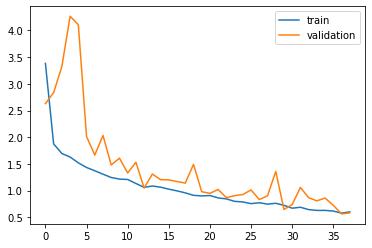

In [53]:
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [54]:
# Score trained model on test data set
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 1s 22ms/step - loss: 0.5549 - accuracy: 0.8261
Test loss: 0.5548563599586487
Test accuracy: 0.8260869383811951


In [55]:
y_pred = model.predict(X_test)

In [56]:
predYClasses = np.argmax(y_pred, axis = 1) 
trueY = np.argmax(y_test, axis = 1) 

In [57]:
# Consumer Matrix
from sklearn.metrics import confusion_matrix

In [58]:
le.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

In [59]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': le.classes_, 'abbreviation': abbreviation})
abbreviation

['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

In [60]:
print("=== Confusion Matrix ===")
cm = confusion_matrix(trueY, predYClasses)
print(cm)

=== Confusion Matrix ===
[[ 4  0  1  0  3  0 35  0  0  0  0  0]
 [ 0 51  3  0  0  0  0  0  0  1  1  0]
 [ 0  4 29  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 87  0  0  0  3  1  2  1  0]
 [ 0  0  1  0 31  1  0  0  1  0  0  0]
 [ 0  1  1  1  0 63  2  0  0  0  0  0]
 [ 0  0  0  0  1  1 84  0  2  0  0  0]
 [ 0  6  0  0  0  1  0 20  0  0  5  0]
 [ 0 14  3  1  0  0  0  0 57  5  3  0]
 [ 0  2  1  0  0  0  0  0  2 25  0  0]
 [ 0  0  0  1  0  0  0  0  0  2 78  0]
 [ 0  6  0  0  0  0  1  0  2  0  1 60]]


<Figure size 1152x576 with 0 Axes>

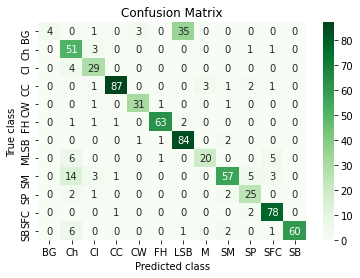

In [61]:
# Confusion matrix with class labels
plt.figure(figsize=(16,8))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cm, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59].

Actual Encoded Class 6
Actual Class name: Loose Silky-bent
Predicted Encoded Class 6
Predicted Plan name: Loose Silky-bent


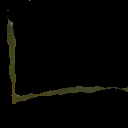

In [62]:
i = 2 
print(f'Actual Encoded Class {trueY[i]}')
print(f'Actual Class name: {le.classes_[trueY[i]]}')
print(f'Predicted Encoded Class {predYClasses[i]}')
print(f'Predicted Plan name: {le.classes_[predYClasses[i]]}')
cv2_imshow(X_test[i]*255)

Actual Encoded Class 5
Actual Class name: Fat Hen
Predicted Encoded Class 5
Predicted Plan name: Fat Hen


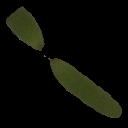

In [63]:
i = 3 
print(f'Actual Encoded Class {trueY[i]}')
print(f'Actual Class name: {le.classes_[trueY[i]]}')
print(f'Predicted Encoded Class {predYClasses[i]}')
print(f'Predicted Plan name: {le.classes_[predYClasses[i]]}')
cv2_imshow(X_test[i]*255)

Actual Encoded Class 10
Actual Class name: Small-flowered Cranesbill
Predicted Encoded Class 10
Predicted Plan name: Small-flowered Cranesbill


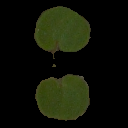

In [64]:
i = 33
print(f'Actual Encoded Class {trueY[i]}')
print(f'Actual Class name: {le.classes_[trueY[i]]}')
print(f'Predicted Encoded Class {predYClasses[i]}')
print(f'Predicted Plan name: {le.classes_[predYClasses[i]]}')
cv2_imshow(X_test[i]*255)

Actual Encoded Class 0
Actual Class name: Black-grass
Predicted Encoded Class 6
Predicted Plan name: Loose Silky-bent


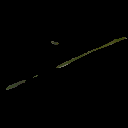

In [65]:
i = 36
print(f'Actual Encoded Class {trueY[i]}')
print(f'Actual Class name: {le.classes_[trueY[i]]}')
print(f'Predicted Encoded Class {predYClasses[i]}')
print(f'Predicted Plan name: {le.classes_[predYClasses[i]]}')
cv2_imshow(X_test[i]*255)

Actual Encoded Class 1
Actual Class name: Charlock
Predicted Encoded Class 1
Predicted Plan name: Charlock


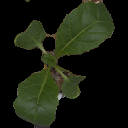

In [66]:
i = 59
print(f'Actual Encoded Class {trueY[i]}')
print(f'Actual Class name: {le.classes_[trueY[i]]}')
print(f'Predicted Encoded Class {predYClasses[i]}')
print(f'Predicted Plan name: {le.classes_[predYClasses[i]]}')
cv2_imshow(X_test[i]*255)

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#0e92ea"> Assignment Completed

Project work is checked in to github on below path:

https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-deepkanpur